In [1]:
cd((@__DIR__) * raw"\..")
include("../table_reader.jl")
include("../utils/Missing_values.jl")

truncate_MV (generic function with 1 method)

In [2]:
series=extract_series("TX_STAID000031.txt",plot=false)
series=truncate_MV(series,"TX")
years=unique(Dates.year.(series.DATE))

include("../utils/Simulation.jl")
Days_list=GatherYearScenario(series[!,2],series.DATE)
avg_day=mean.(Days_list)
max_day=maximum.(Days_list)
df_month = @chain series begin
    @transform(:TEMP = series[!,2]) #Give a common name for TX, TN, etc...
    @transform(:MONTH = month.(:DATE)) #add month column
    @by(:MONTH, :MONTHLY_MEAN = mean(:TEMP), :MONTHLY_STD = std(:TEMP), :MONTHLY_MAX = maximum(:TEMP)) # grouby MONTH + takes the mean/std in each category 
end

#Imputing missing values
# include("utils/Missing_values.jl")
# ImputeMissingValues!(series[!,2],series.DATE)
# N=length(series[!,2])

12×4 DataFrame
 Row │ MONTH  MONTHLY_MEAN  MONTHLY_STD  MONTHLY_MAX 
     │ Int64  Float64       Float64      Float64     
─────┼───────────────────────────────────────────────
   1 │     1       1.17685     0.332309         2.12
   2 │     2       1.28727     0.331852         2.27
   3 │     3       1.54382     0.311683         2.61
   4 │     4       1.79017     0.303244         2.62
   5 │     5       2.19996     0.325811         3.19
   6 │     6       2.54889     0.309155         3.6
   7 │     7       2.85561     0.300014         4.06
   8 │     8       2.80813     0.278482         3.64
   9 │     9       2.47622     0.280431         3.3
  10 │    10       2.06394     0.312442         3.09
  11 │    11       1.52238     0.335048         2.43
  12 │    12       1.23495     0.328123         2.31

## I. Series filtered by removing a trigonometric periodicity

In [3]:
include("../utils/periodicity.jl")
trigo_function=fitted_periodicity_fonc_stepwise(series[!,2],series.DATE)
periodicity=trigo_function.(series.DATE)
x=series[!,2]-periodicity
period=trigo_function.(Date(0):Date(1)-Day(1))

366-element Vector{Float64}:
 1.1340543550640587
 1.1252575718049904
 1.1253283362382658
 1.1311577426972417
 1.1361737081820835
 1.1359982555157717
 1.1316350384815326
 1.1278487461450717
 1.1284929790485834
 1.132876218786665
 ⋮
 1.195134594117916
 1.1815436166236033
 1.1668565728784066
 1.1585160113620188
 1.1588358590232388
 1.1624516561230154
 1.1611804549559963
 1.1514278031064487
 1.137246386435572

## Segmenting the dataset by month

In [4]:
include("../utils/Separation.jl")
Monthly_date=MonthlySeparateDates(series.DATE)
Monthly_temp=MonthlySeparateX(x,series.DATE)

12-element Vector{Vector{AbstractVector}}:
 [[0.14594564493594153, 0.2747424281950097, 0.3746716637617342, 0.07884225730275829, 0.16382629181791653, 0.30400174448422845, 0.27836496151846757, -0.1278487461450717, -0.33849297904858333, -0.05287621878666493  …  -0.5871203203856138, -0.6624182092232491, -0.33639382136581375, -0.05061320690586868, -0.3530089814945673, -0.12060252264128546, 0.047826909100421755, 0.05074320092512208, 0.04403144157636141, 0.08175200412511652], [0.3659456449359413, -0.09525757180499039, -0.17532833623826571, -0.01115774269724179, -0.32617370818208347, -0.03599825551577163, 0.1983649615184675, 0.12215125385492831, -0.5084929790485833, -0.5328762187866649  …  0.2628796796143862, 0.43758179077675097, 0.29360617863418614, -0.060613206905868466, 0.13699101850543283, 0.009397477358714434, 0.1978269091004219, 0.05074320092512208, 0.0640314415763612, -0.09824799587488364], [0.2659456449359414, 0.46474242819500966, 0.4546716637617343, 0.5688422573027585, 0.5838262918179

## Autocorrelations

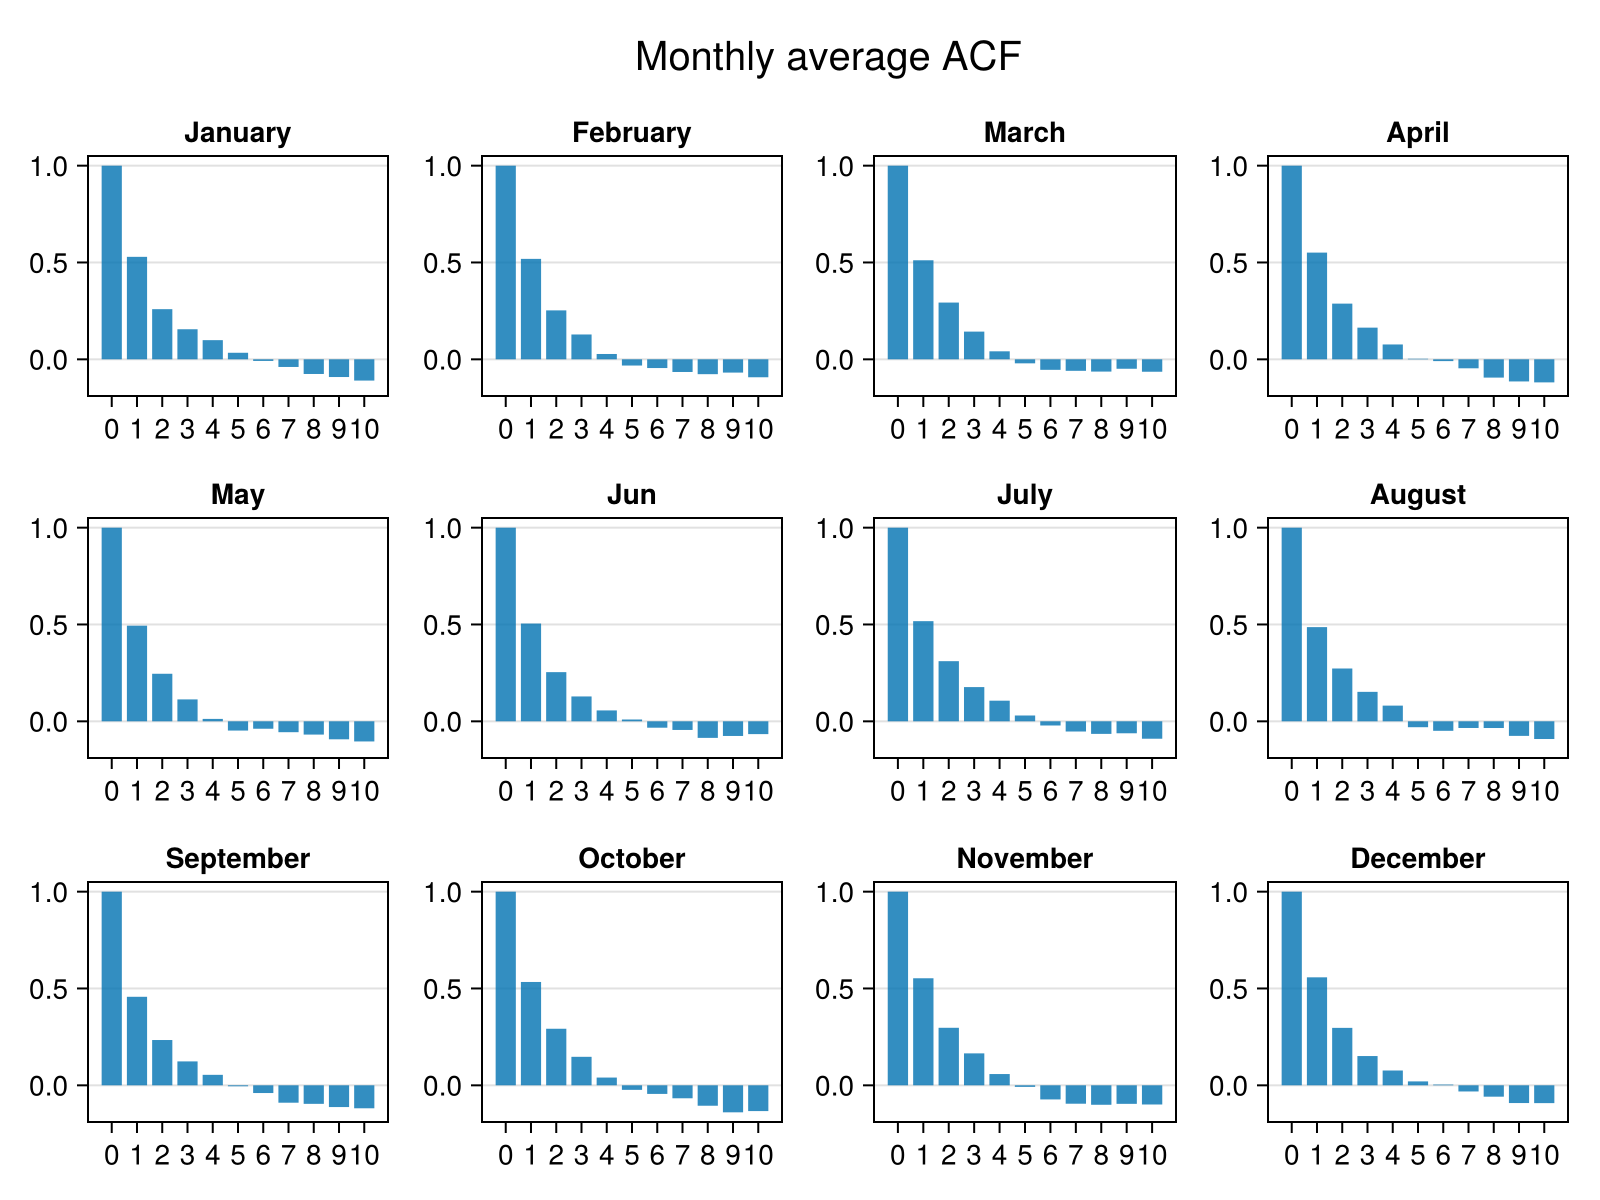

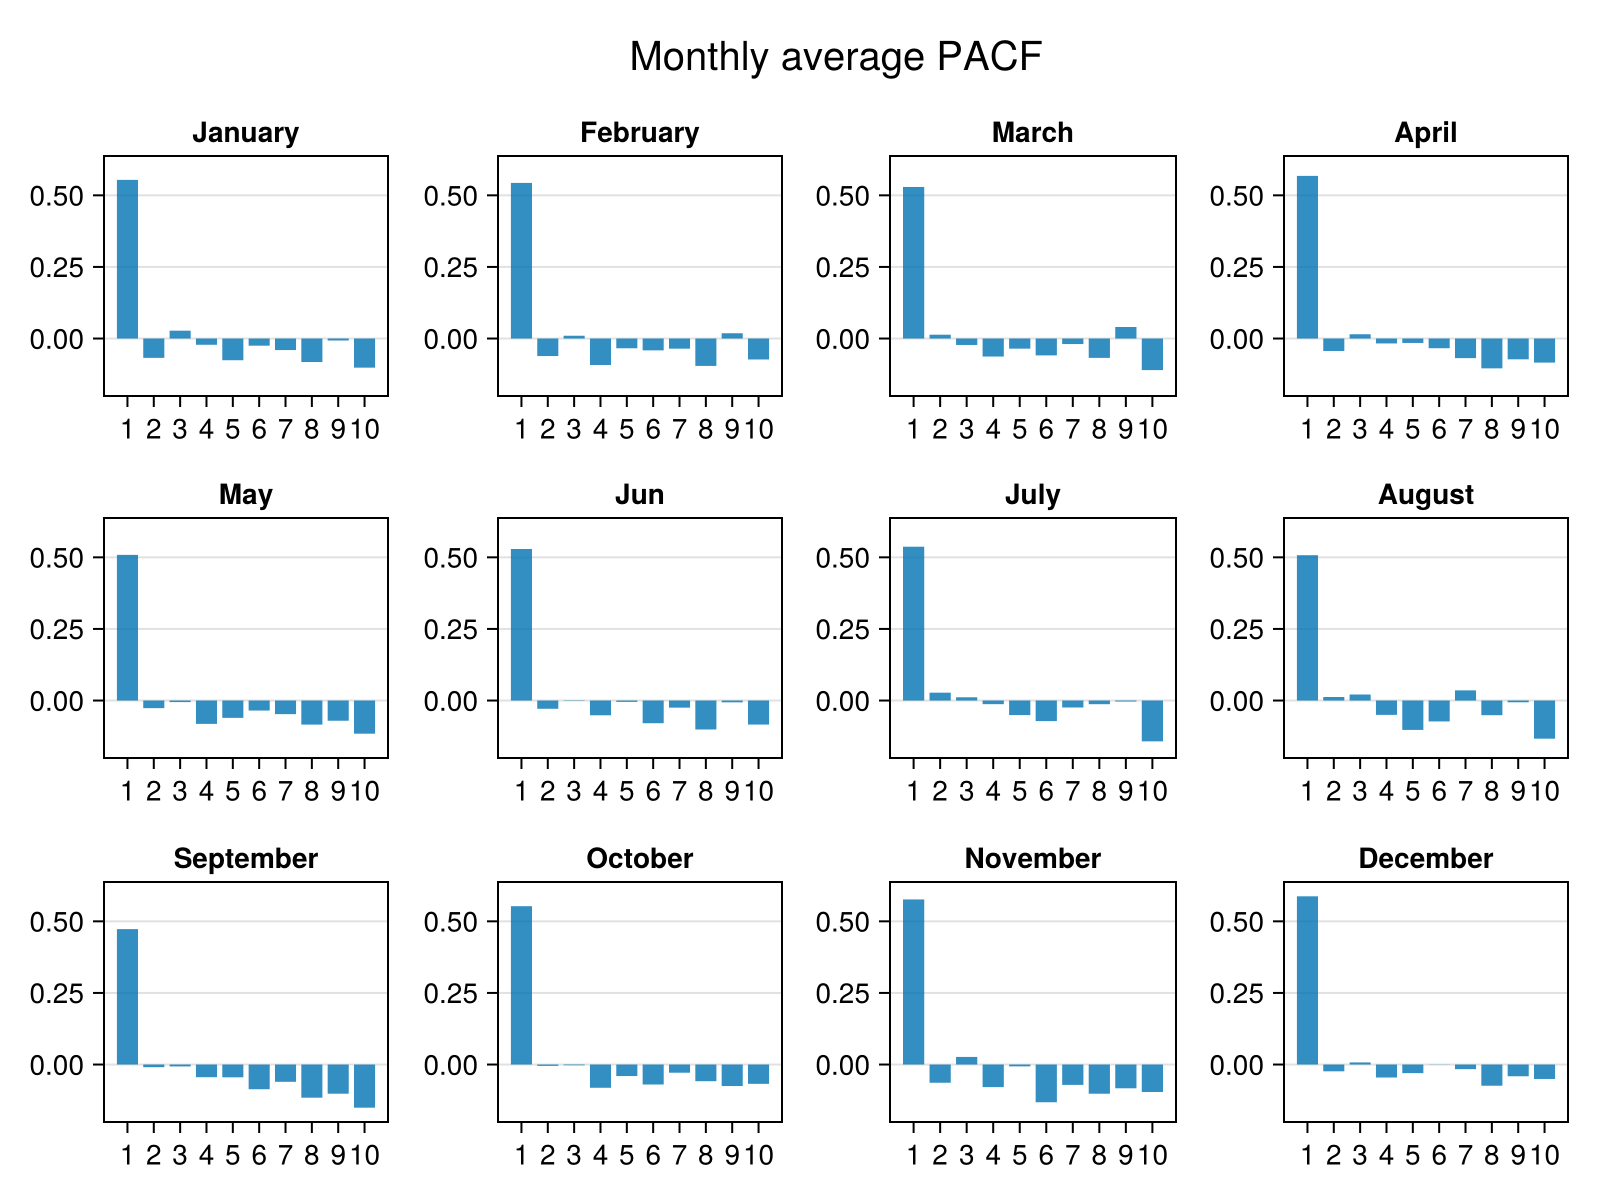

CairoMakie.Screen{IMAGE}


In [5]:
include("../utils/ACF_PACF.jl")
display(MonthlyACF(Monthly_temp))
display(MonthlyPACF(Monthly_temp))

For each month, it still looks like an AR(1) model

# Estimation AR(1)

## Estimation

ERROR: LoadError: too many parameters for type AbstractInterpolation
Stacktrace:
 [1] top-level scope
   @ C:\Users\goninarn\.julia\packages\SparseConnectivityTracer\litqn\ext\SparseConnectivityTracerDataInterpolationsExt.jl:28
 [2] include
   @ .\Base.jl:557 [inlined]
 [3] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::String)
   @ Base .\loading.jl:2881
 [4] top-level scope
   @ stdin:6
in expression starting at C:\Users\goninarn\.julia\packages\SparseConnectivityTracer\litqn\ext\SparseConnectivityTracerDataInterpolationsExt.jl:3
in expression starting at stdin:6
┌ Error: Error during loading of extension SparseConnectivityTracerDataInterpolationsExt of SparseConnectivityTracer, use `Base.retry_load_extensions()` to retry.
│   exception = 1-element ExceptionStack:
Failed to precompile SparseConnectivityTracerDataInterpolationsExt [

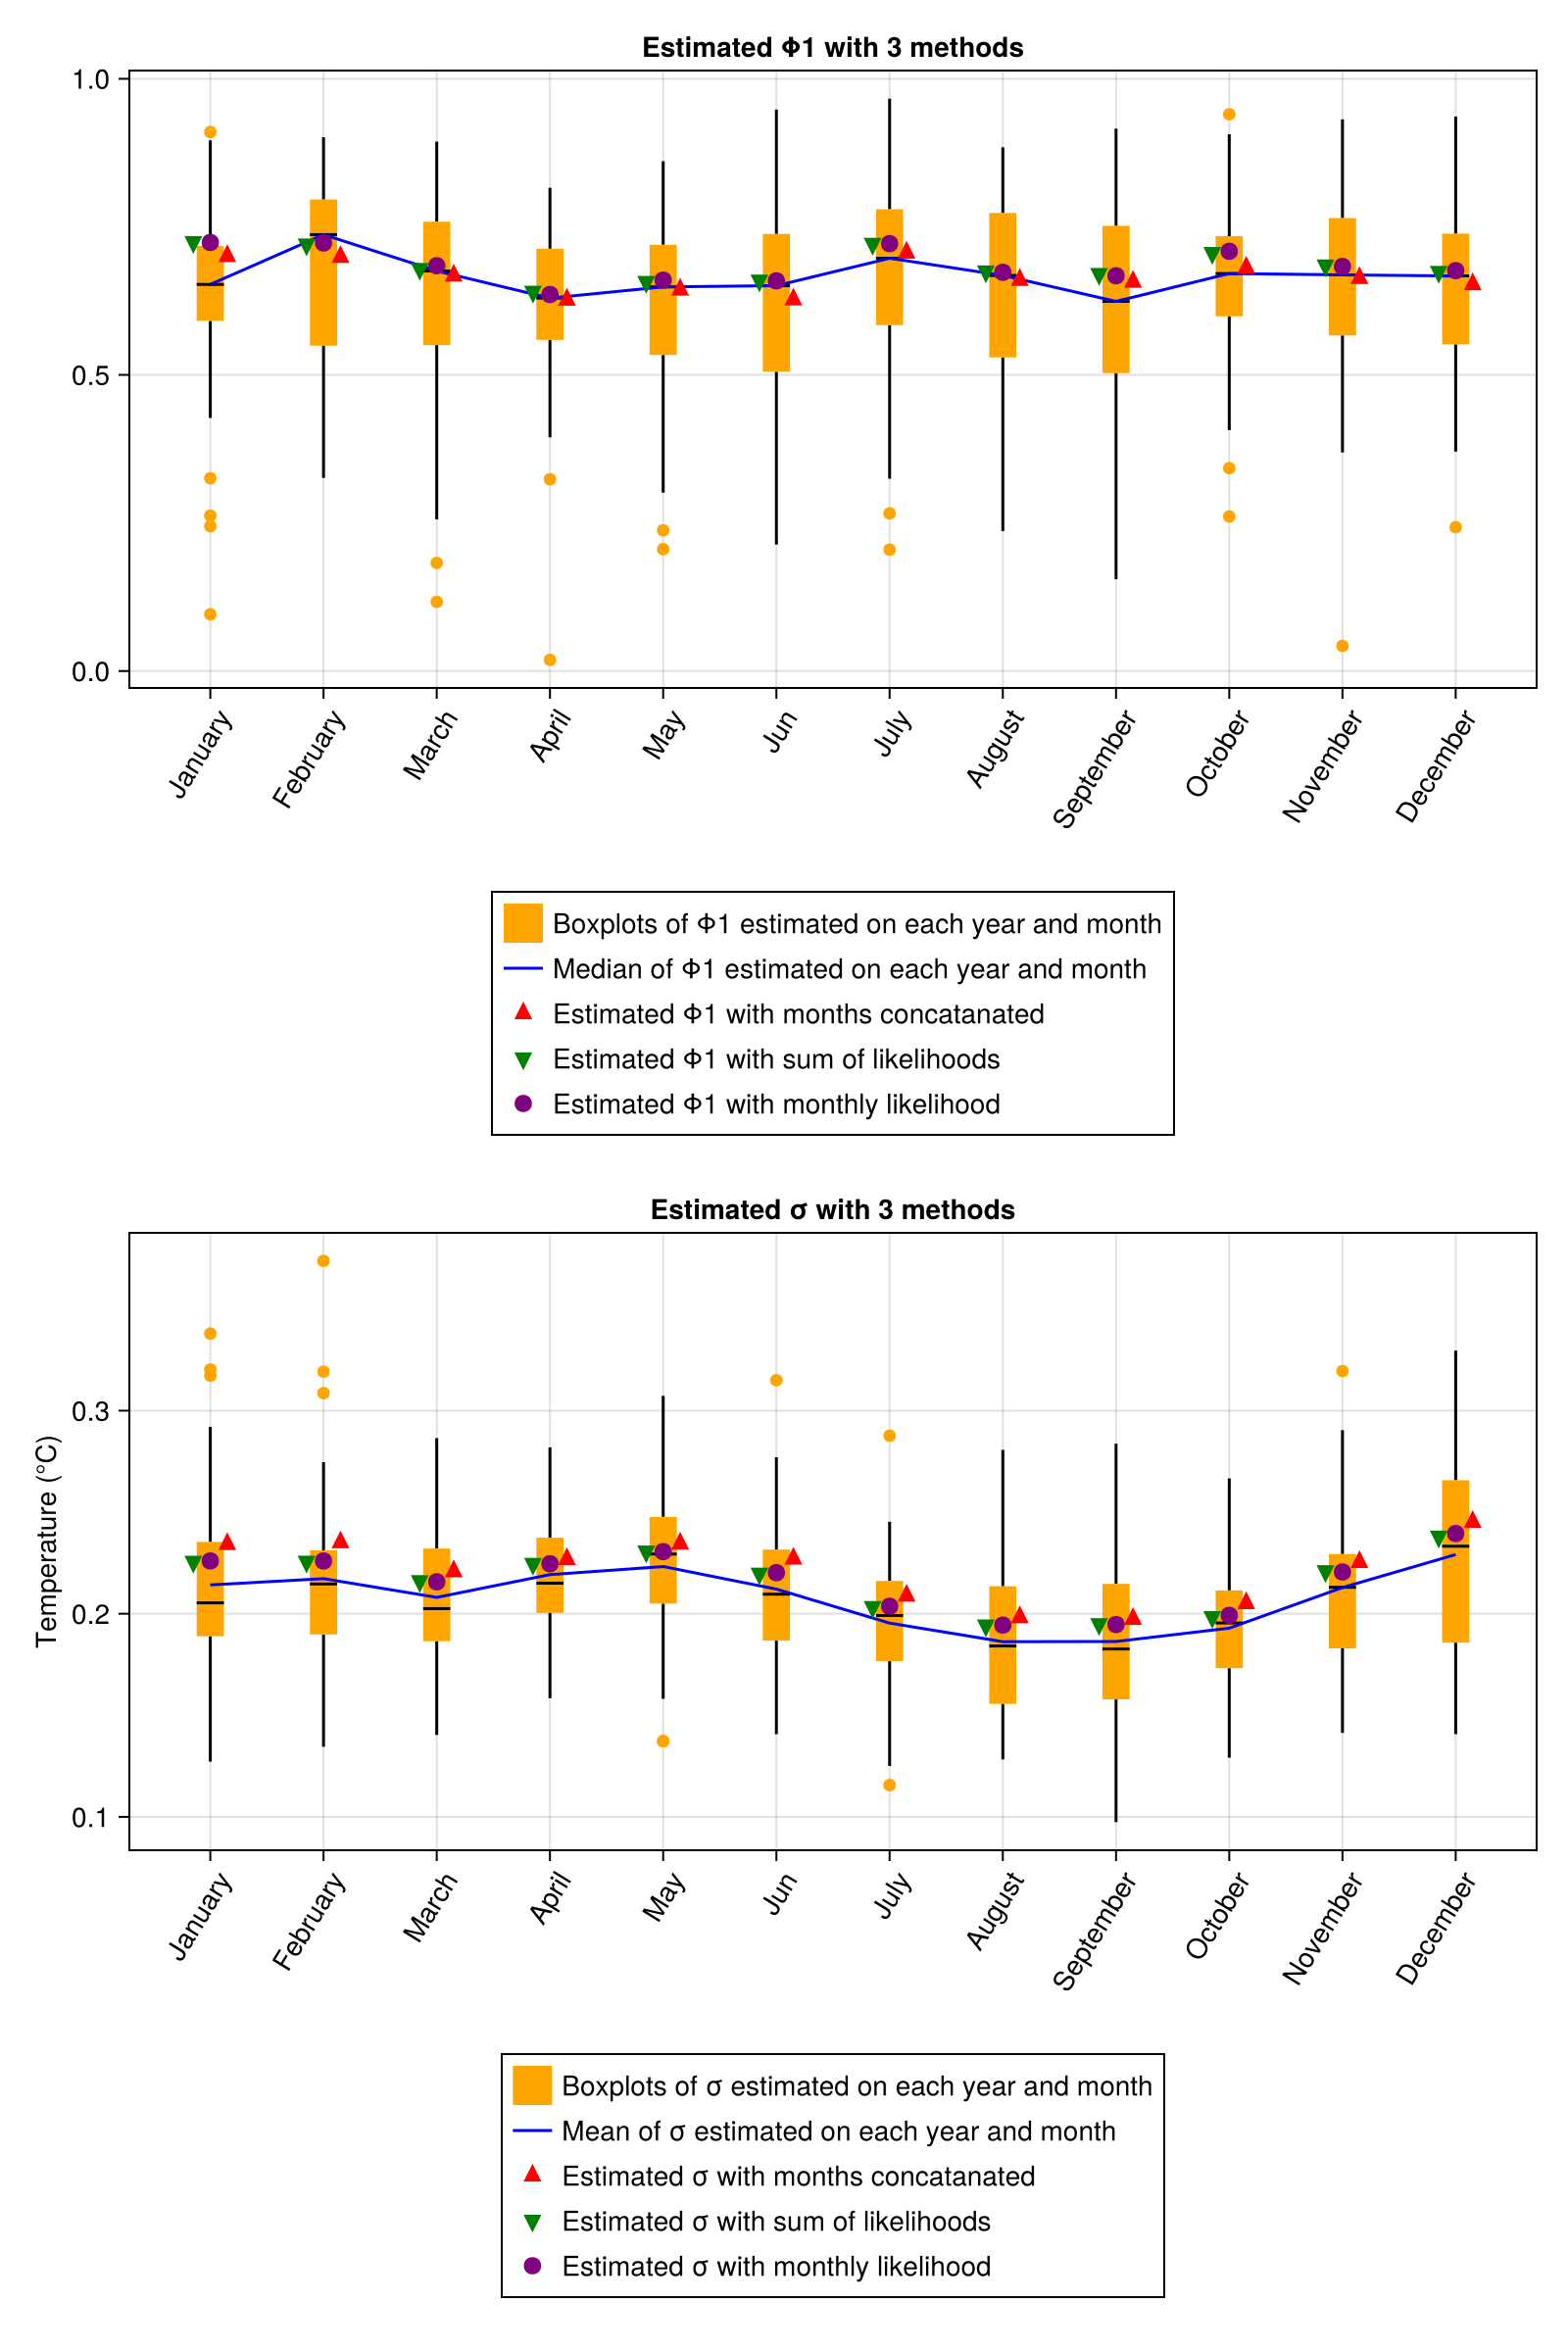

CairoMakie.Screen{IMAGE}


In [6]:
include(raw"..\utils\Estimation.jl")
Params, figure= AllEstimation(x, Date_vec = series.DATE, lineplot=true)
display(figure)

## Simulation

### With monthly likelihoods

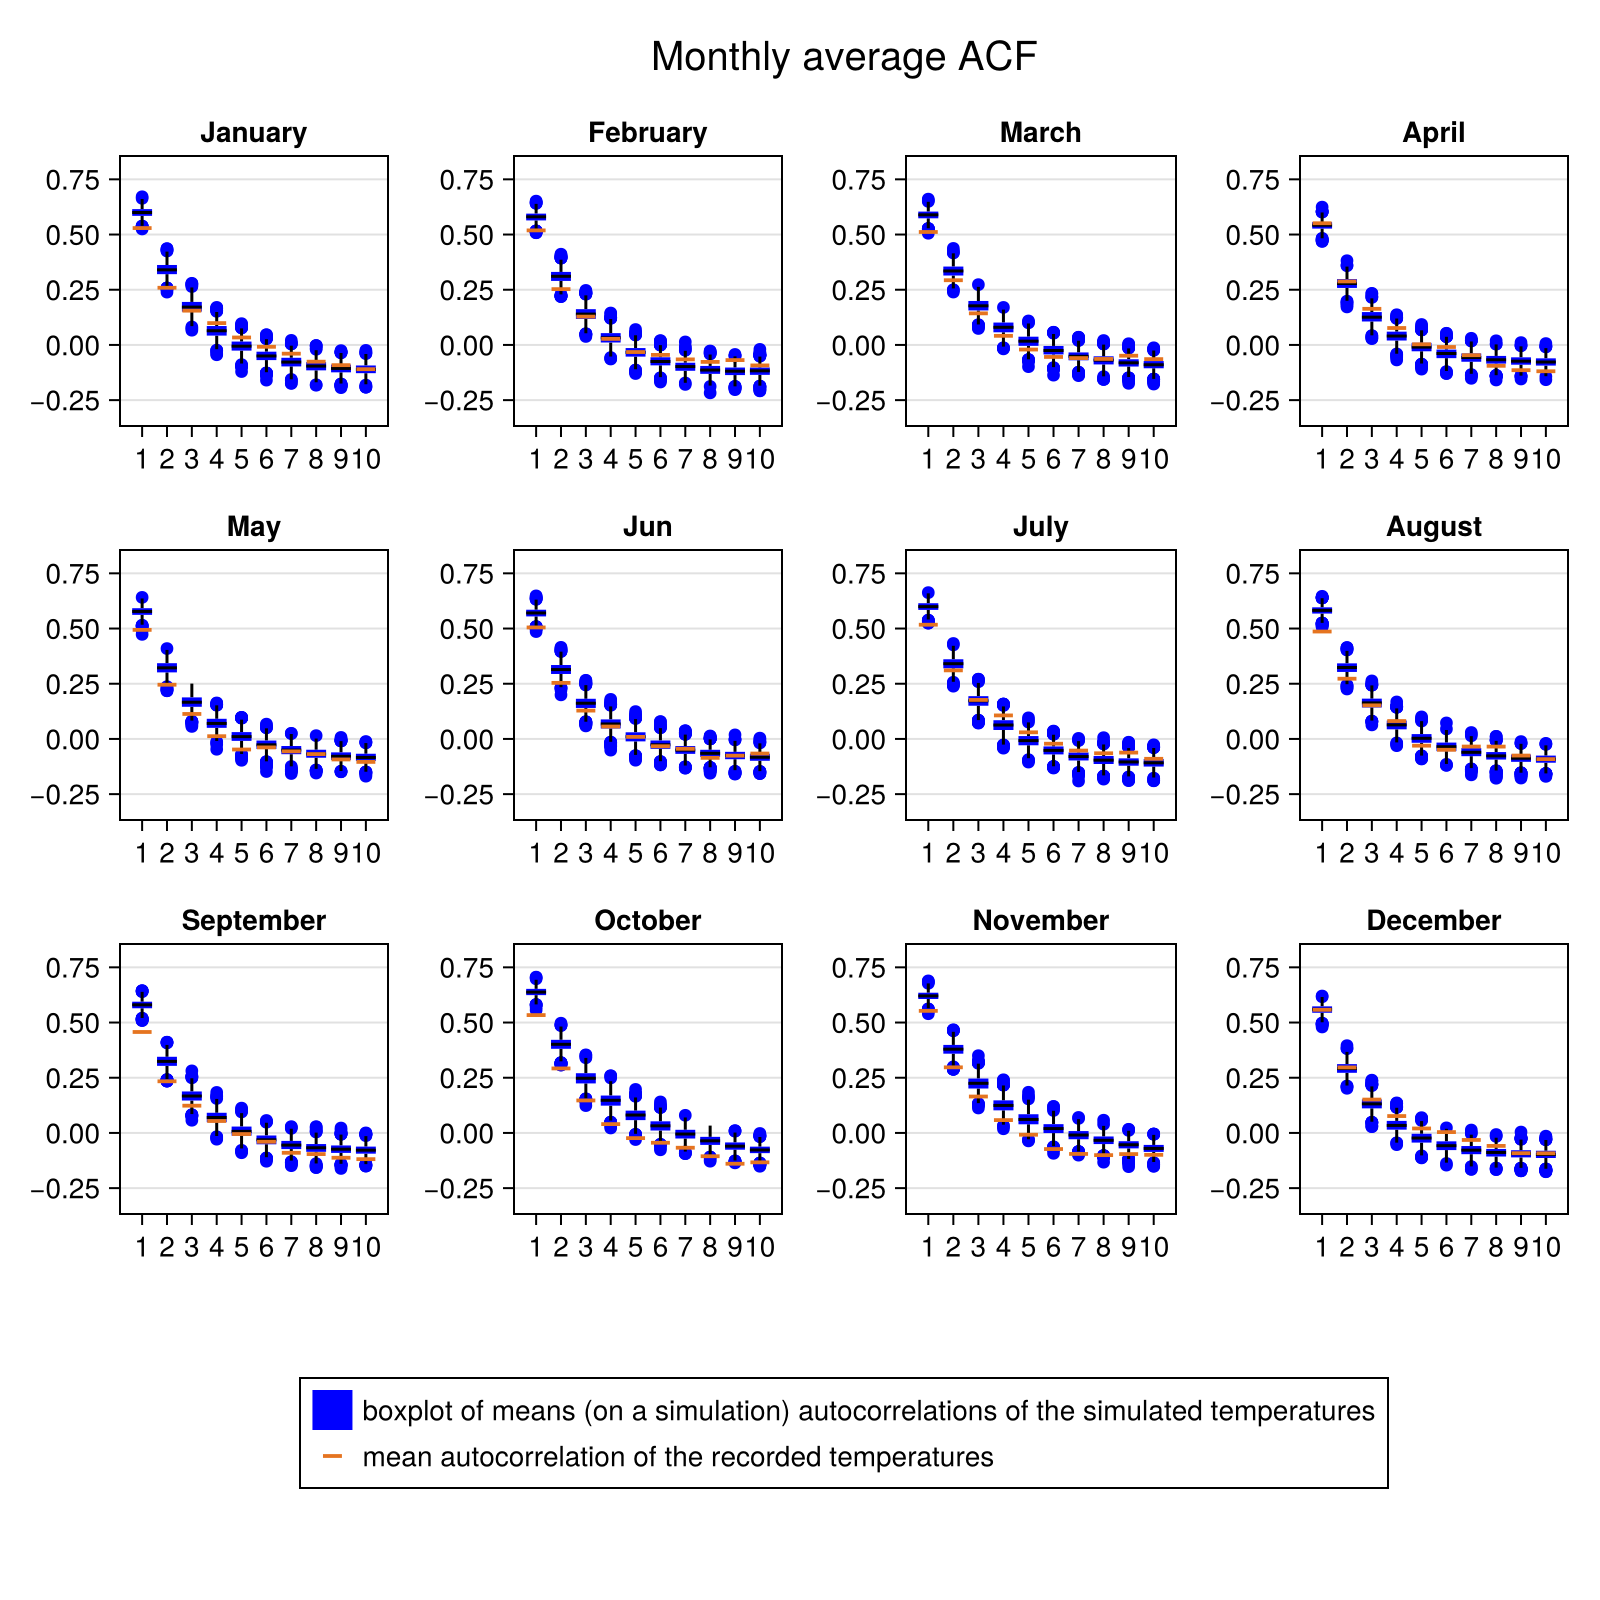

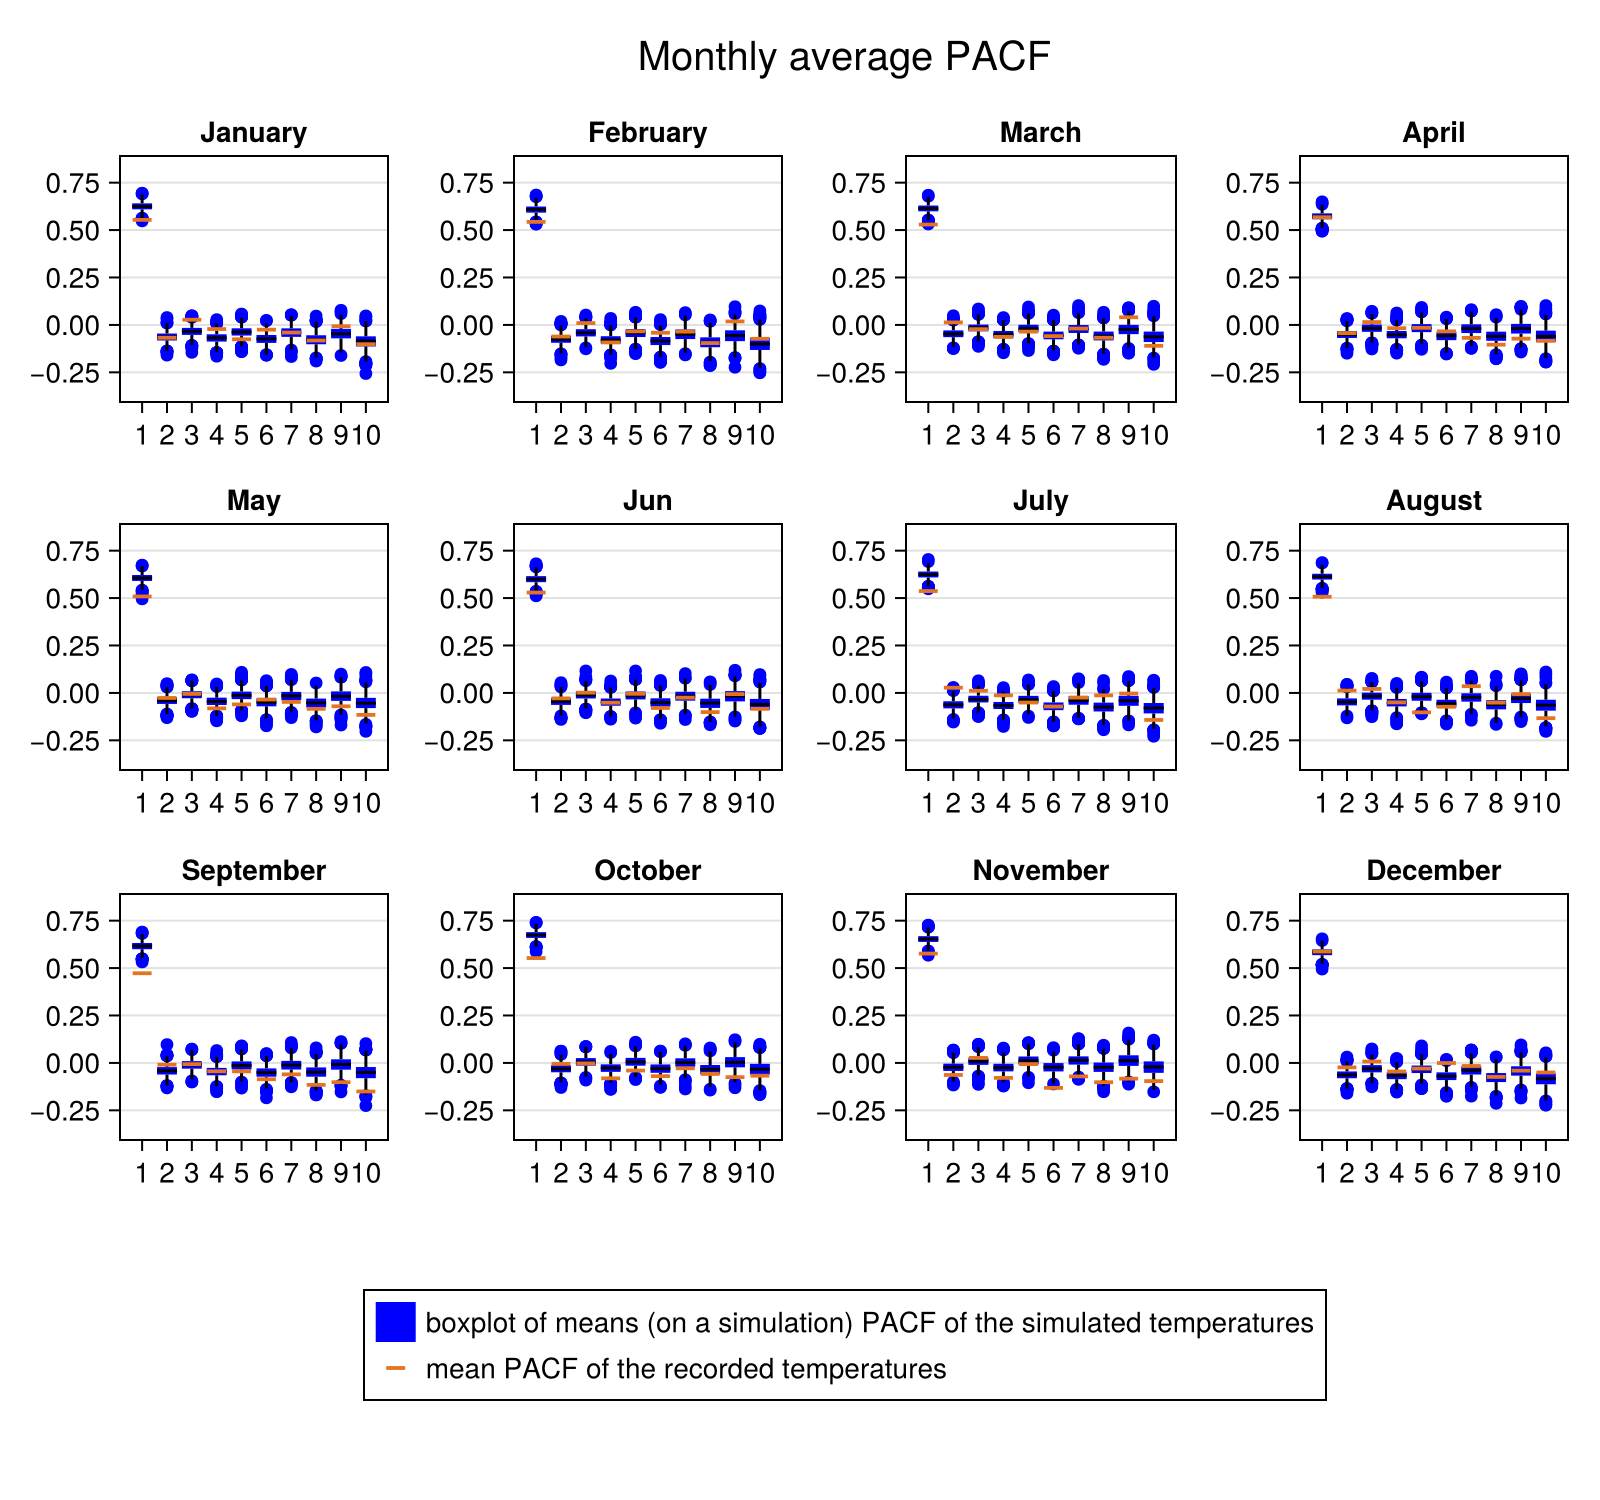

CairoMakie.Screen{IMAGE}


In [7]:
Φ_month_mean,σ_month_mean=TakeParameters(Params,"monthlyLL")
sample_ = SimulateScenarios(Monthly_temp[1][1][1],series.DATE[1]:series.DATE[end],Φ_month_mean,σ_month_mean,period,n=2000)
year_sample = GatherYearScenarios(sample_,series.DATE[1]:series.DATE[end])
# display(PlotYearCurves([period,mean.(year_sample)],["Periodicity estimation","Mean simulated temperatures"],"Average daily temperature during a year (centered)"))
# display(PlotYearCurves([period,avg_day,max_day],
# ["Periodicity estimation","Average recorded temperatures","Maximum recorded temperatures","Simulated temperatures range","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
# "Average daily temperature during a year (centered)",
# [(minimum.(year_sample),maximum.(year_sample)),(quantile.(year_sample,0.25),quantile.(year_sample,0.75))],
# [("#009bff",0.2),("#009bff",0.5)],
# colors=["blue","orange","red"]
# ))
# display(PlotYearCurves([maximum.(year_sample) .- minimum.(year_sample) , quantile.(year_sample,0.75) .- quantile.(year_sample,0.25)],
# ["Simulated temperatures range" ,"Simulated temperatures interquartile range, p ∈ [0.25,0.75]"],
# "Simulated temperatures interquartile range"
# ))
# display.(WrapPlotMonthlyStats(df_month, sample_, series.DATE[1]:series.DATE[end]))
display(Plot_Sample_MonthlyACF(sample_,series.DATE[1]:series.DATE[end],Monthly_temp))
display(Plot_Sample_MonthlyPACF(sample_,series.DATE[1]:series.DATE[end],Monthly_temp))

In [8]:
mean(Error_MonthlyACF(sample_,series.DATE[1]:series.DATE[end],Monthly_temp))

0.04521652219937812

In [9]:
MPACF=Error_MonthlyPACF(sample_,series.DATE[1]:series.DATE[end],Monthly_temp)
println(mean(MPACF[1,:]))
println(mean(MPACF[2,:]))

0.04278463781226098
0.0423586904589506


# Estimation AR(2)

## Estimation

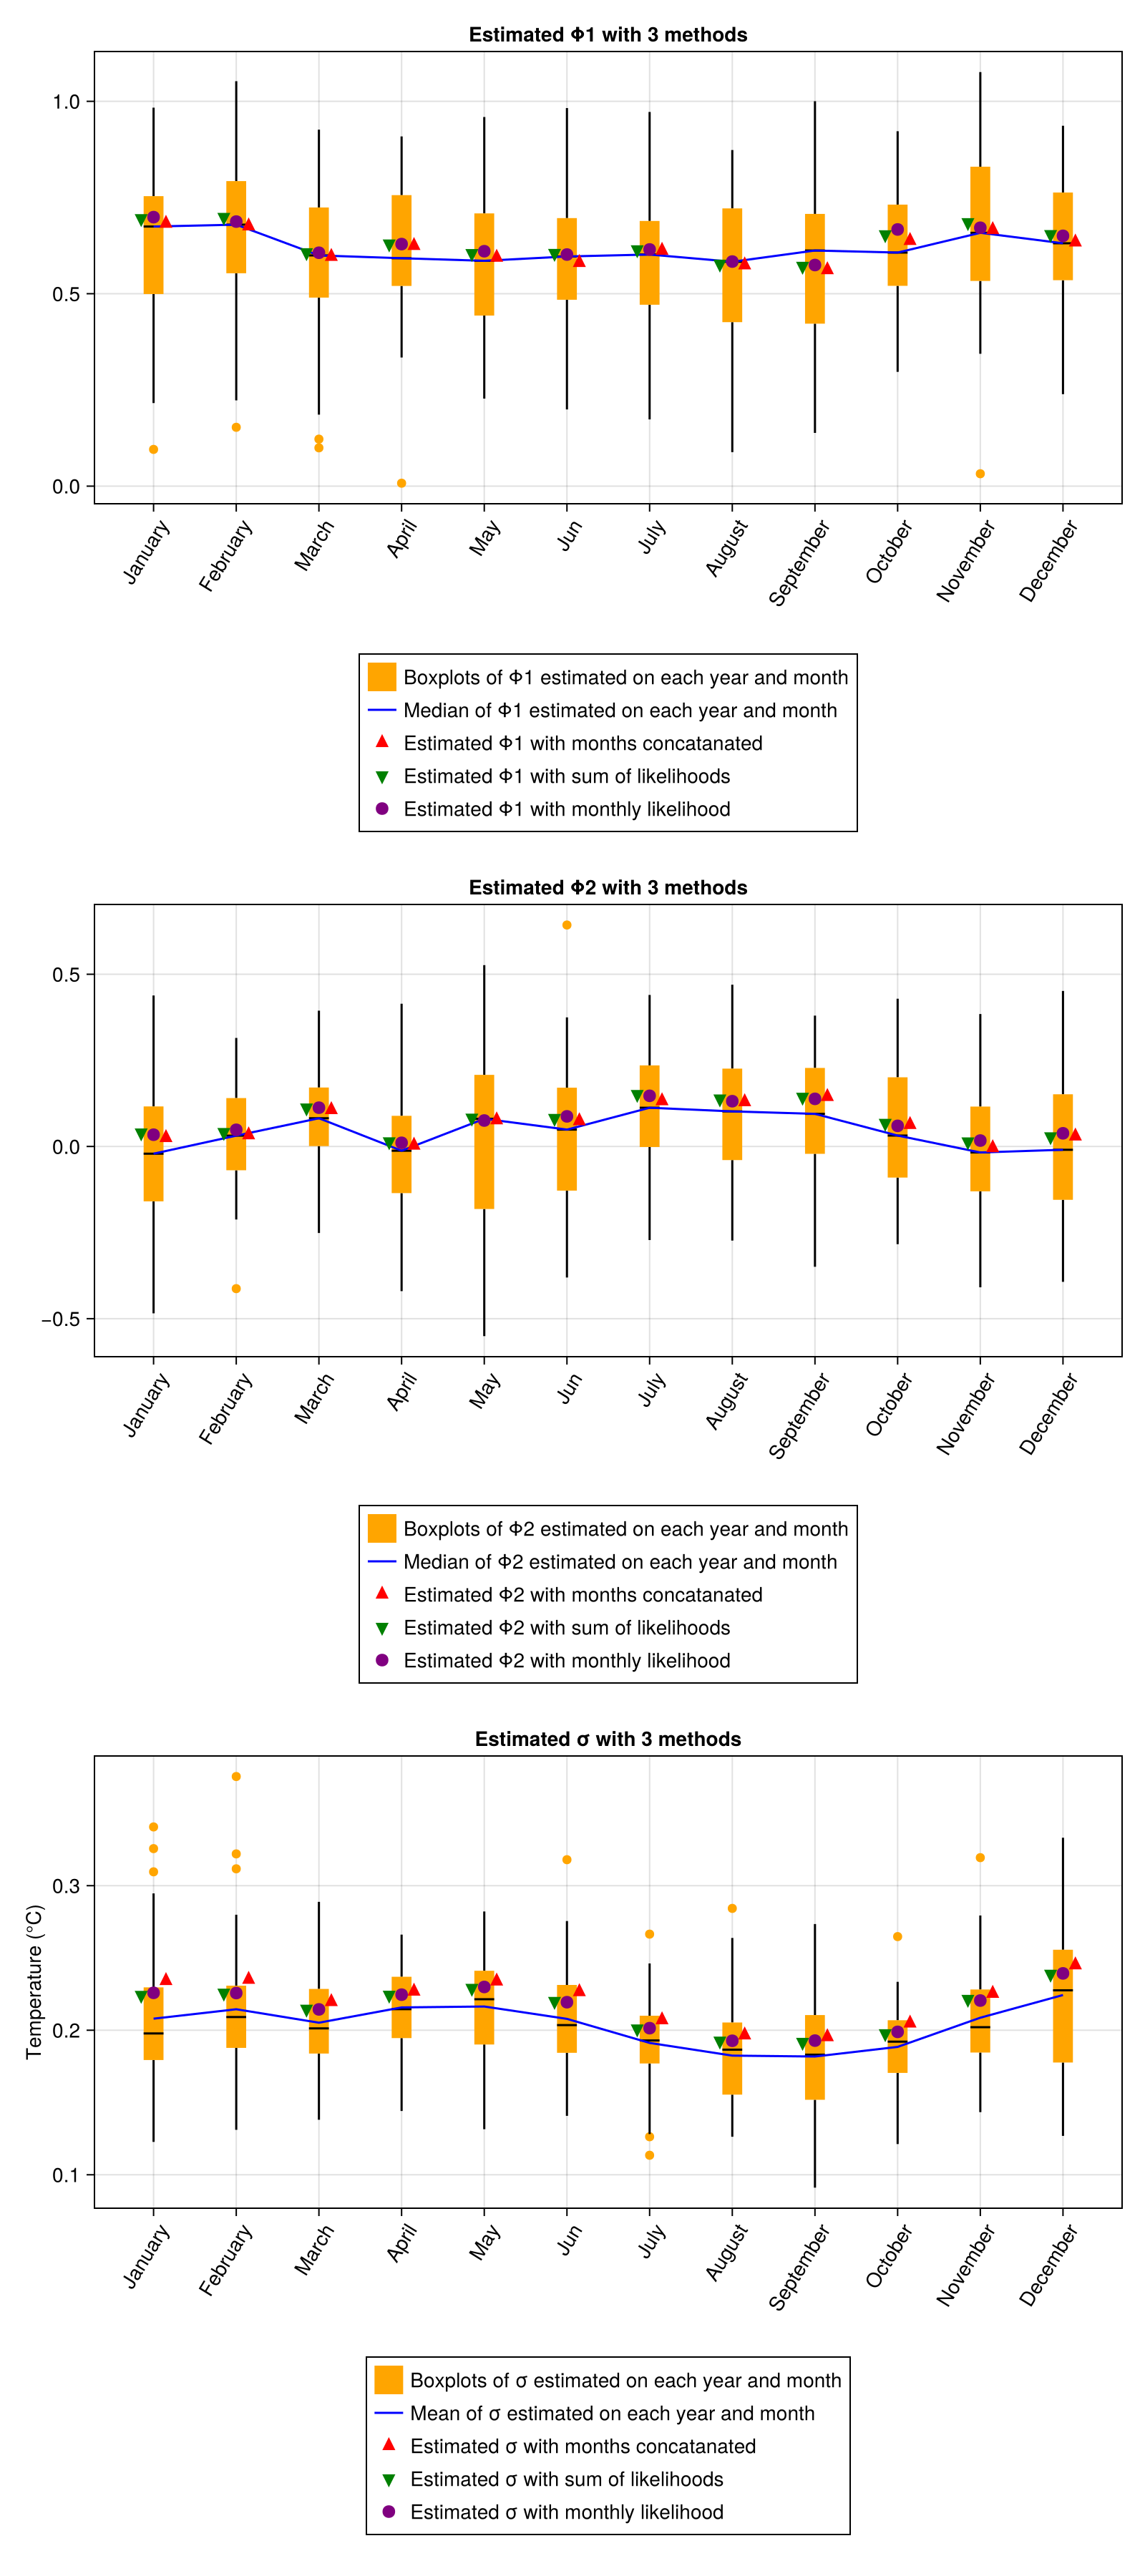

CairoMakie.Screen{IMAGE}


In [10]:
include("../utils/Estimation.jl")
Params, figure= AllEstimation(x, 2, Date_vec=series.DATE, lineplot=true)
display(figure)

### Estimation and simulation with monthly likelihoods

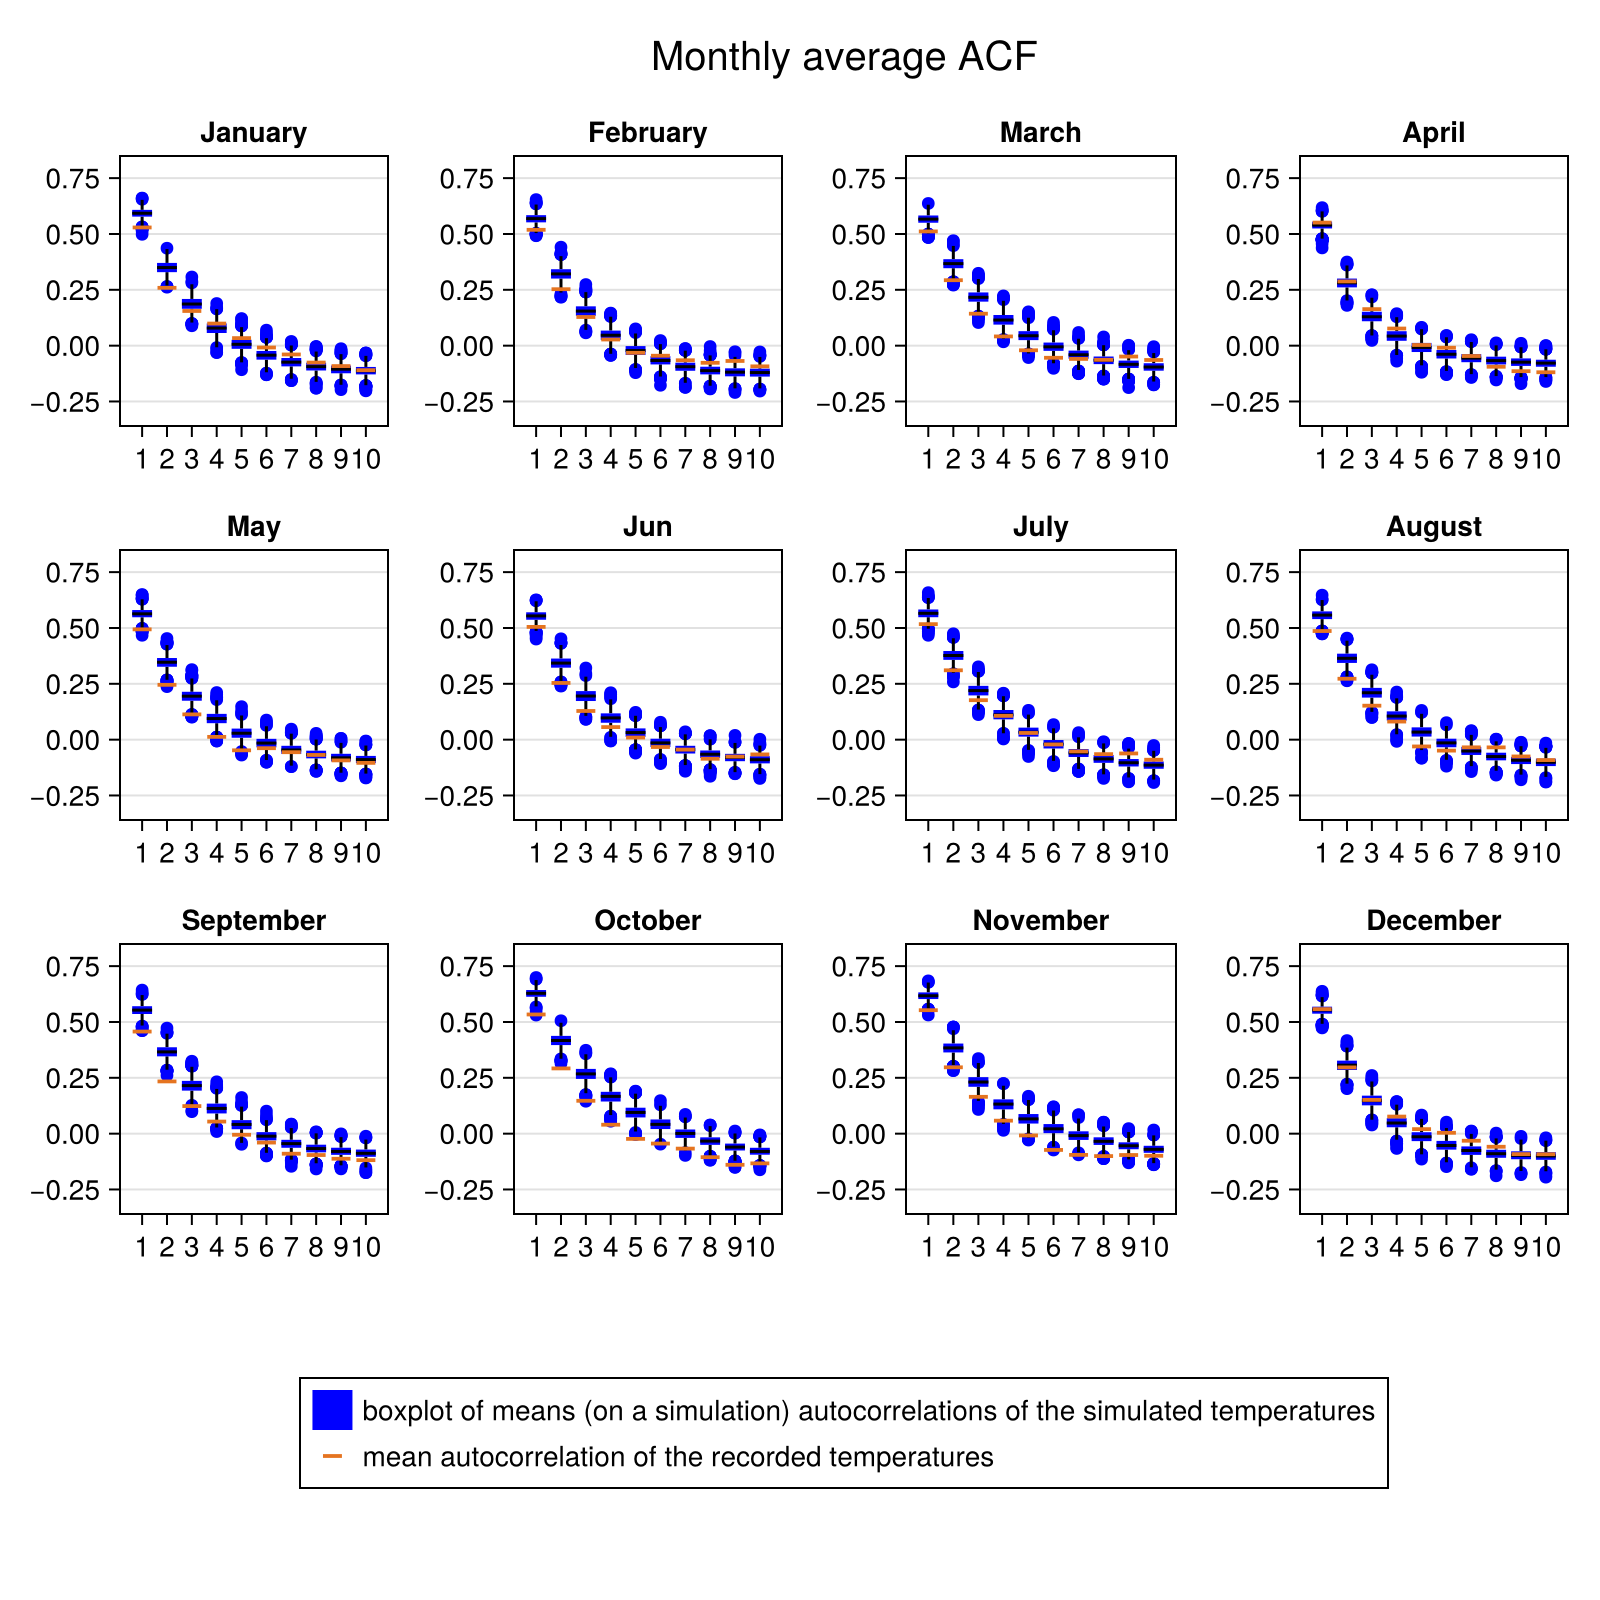

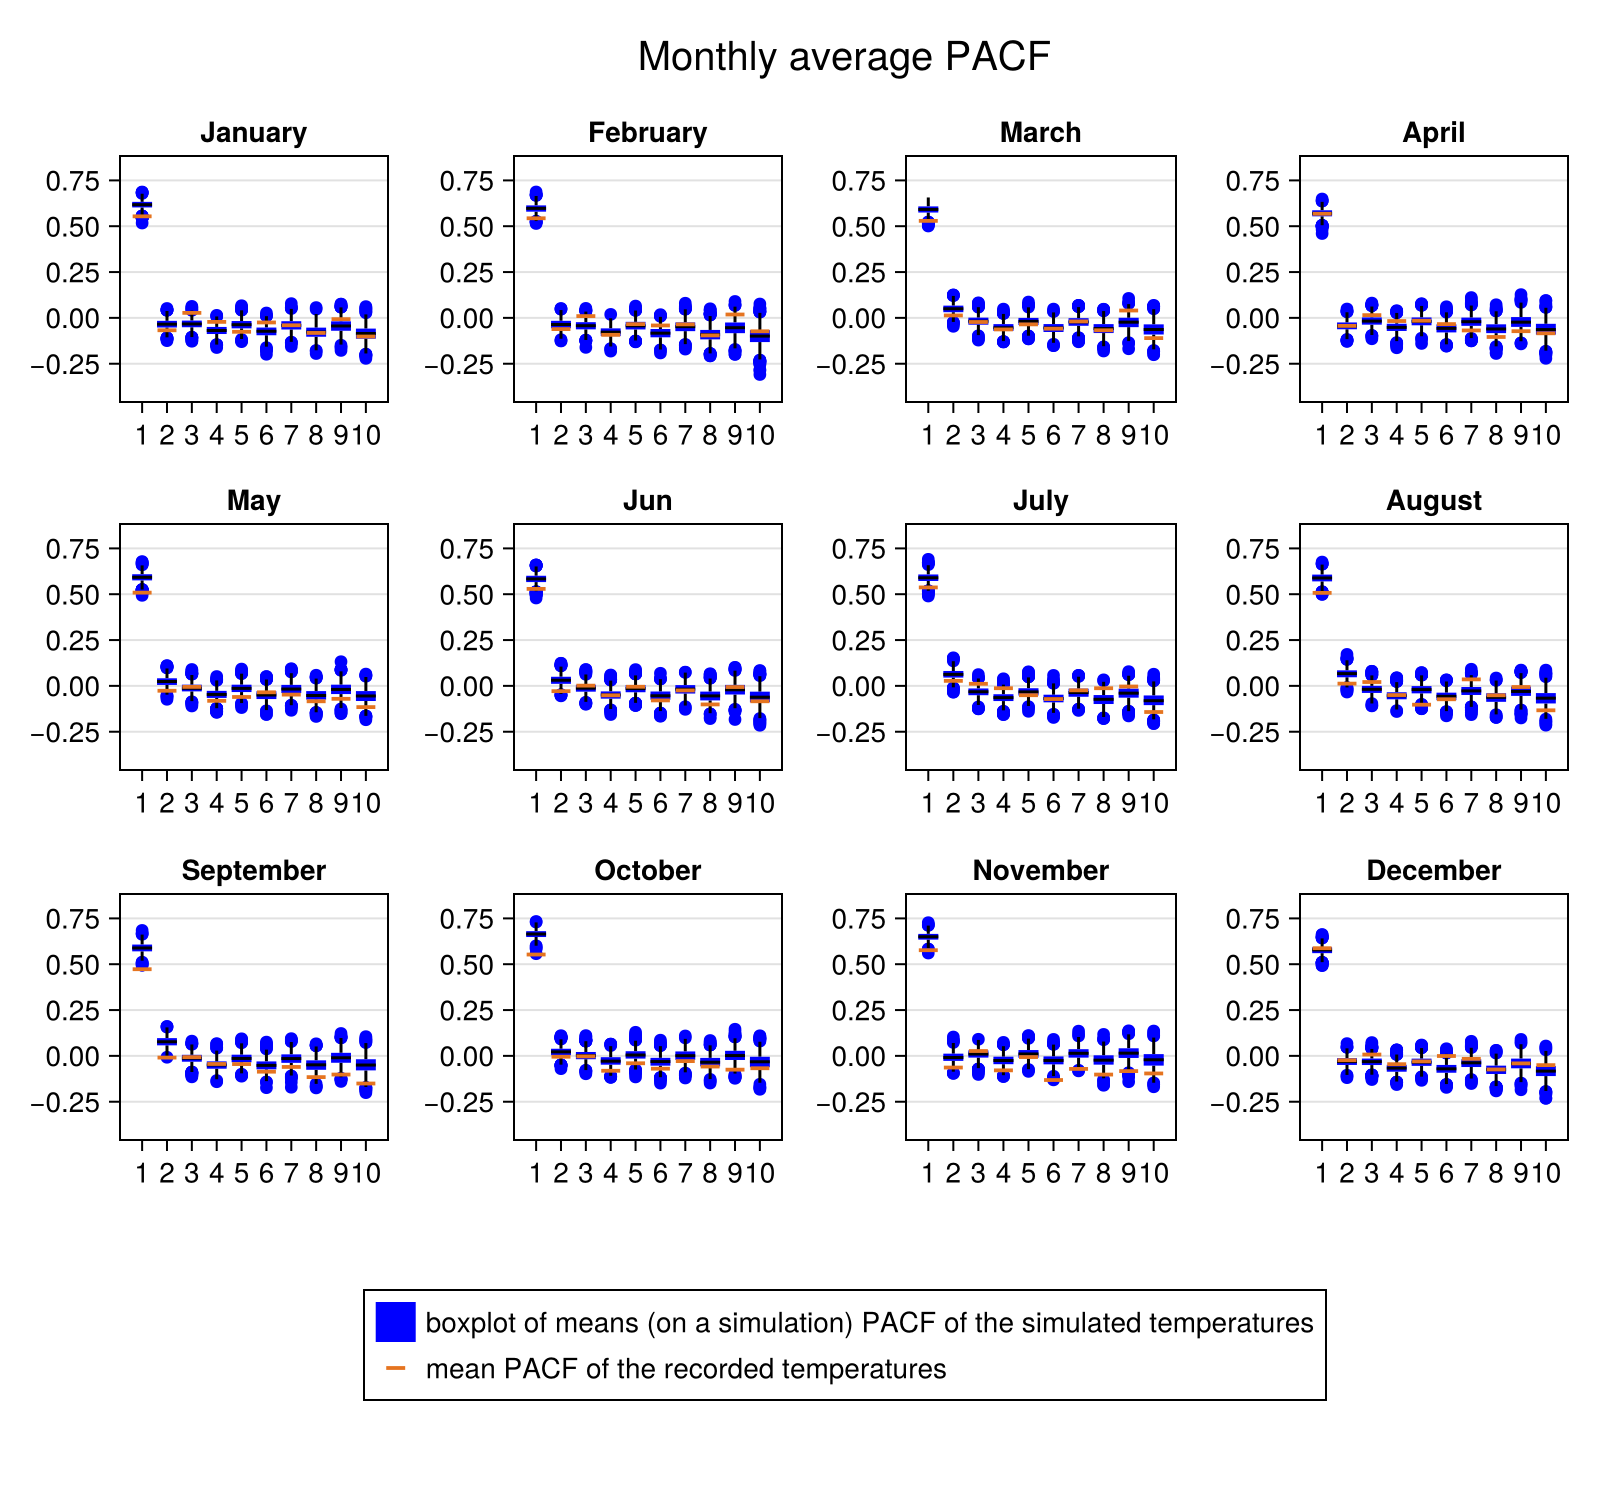

CairoMakie.Screen{IMAGE}


In [11]:
Φ_month_mean,σ_month_mean=TakeParameters(Params,"monthlyLL")
sample_ = SimulateScenarios(Monthly_temp[1][1][1:2],series.DATE[1]:series.DATE[end],Φ_month_mean,σ_month_mean,period,n=2000)
year_sample = GatherYearScenarios(sample_,series.DATE[1]:series.DATE[end])
# display(PlotYearCurves([period,mean.(year_sample)],["Periodicity estimation","Mean simulated temperatures"],"Average daily temperature during a year (centered)"))
# display(PlotYearCurves([period,avg_day,max_day],
# ["Periodicity estimation","Average recorded temperatures","Maximum recorded temperatures","Simulated temperatures range","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
# "Average daily temperature during a year (centered)",
# [(minimum.(year_sample),maximum.(year_sample)),(quantile.(year_sample,0.25),quantile.(year_sample,0.75))],
# [("#009bff",0.2),("#009bff",0.5)],
# colors=["blue","orange","red"]
# ))
# display(PlotYearCurves([maximum.(year_sample) .- minimum.(year_sample) , quantile.(year_sample,0.75) .- quantile.(year_sample,0.25)],
# ["Simulated temperatures range" ,"Simulated temperatures interquartile range, p ∈ [0.25,0.75]"],
# "Simulated temperatures interquartile range"
# ))
# display.(WrapPlotMonthlyStats(df_month, sample_, series.DATE[1]:series.DATE[end]))
display(Plot_Sample_MonthlyACF(sample_,series.DATE[1]:series.DATE[end],Monthly_temp))
display(Plot_Sample_MonthlyPACF(sample_,series.DATE[1]:series.DATE[end],Monthly_temp))

In [12]:
mean(Error_MonthlyACF(sample_,series.DATE[1]:series.DATE[end],Monthly_temp))

0.049289974415399396

In [13]:
MPACF=Error_MonthlyPACF(sample_,series.DATE[1]:series.DATE[end],Monthly_temp)
println(mean(MPACF[1,:]))
println(mean(MPACF[2,:]))

0.043386915936738116
0.041610547495144604


L'AR1 semble légérement mieux que l'AR2 car les différences d'ACF avec les données réels sont légérement plus faible. Mais les différences entre les deux possibilités sont assez faibles.